## ✈️ Análisis de Comportamiento de Clientes en Aerolínea

Objetivo  

**En este análisis exploraremos los datos de clientes inscritos en una membresía de aerolínea y sus vuelos.**

  **Realizaremos limpieza, visualización y evaluación de los datos para obtener insights relevantes.** 


# Fase 1: Exploración y Limpieza

### 0. Importación de librerías

In [355]:
import pandas as pd
import numpy as np
# 📌 1. Configuración para gestión de nulos
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# 📌 2. Configurar pandas para ver todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 📌 3. Configuración para gráficos
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest

In [176]:
# 1. Cargar el dataset de la información de los clientes sin la columna "Unnamed: 0"
df_loyalty = pd.read_csv("Customer_Loyalty_History.csv")
# Vista previa de los datos
display(df_loyalty.head())

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,NaN,Single,Star,3839.75,Standard,2014,7,2018.0,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,NaN,Single,Star,3839.75,Standard,2013,2,NaN,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.79,Standard,2014,10,NaN,NaN


**Carga y Exploración Inicial de Datos**

In [177]:
# 2. Cargar el dataset de la información de la actividad de los vuelos de los clientes sin la columna "Unnamed: 0"
df_flight = pd.read_csv("Customer_Flight_Activity.csv")
# Vista previa de los datos
display(df_flight.head())

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


## 1. Exploración Inicial:
- Realiza una exploración inicial de los datos para identificar posibles problemas, como valores nulos, atípicos o datos faltantes en las columnas relevantes
- Utiliza funciones de Pandas para obtener información sobre la estructura de los datos, la presencia de valores nulos y estadísticas básicas de las columnas involucradas.
- Une los dos conjuntos de datos de la forma más eficiente


*Comenzamos viendo la información de el csv de los datos de los clientes:*

In [178]:
print(f"Tamaño del dataset de clientes: {df_loyalty.shape}")

Tamaño del dataset de clientes: (16737, 16)


In [179]:
print(f"Tamaño del dataset de vuelos: {df_flight.shape}")

Tamaño del dataset de vuelos: (405624, 10)


In [180]:
print(f"El número de filas de la tabla de clientes es {df_loyalty.shape[0]} y tiene {df_loyalty.shape[1]} columnas")
print(f"El número de filas de la tabla de vuelos es {df_flight.shape[0]} y tiene {df_flight.shape[1]} columnas")

El número de filas de la tabla de clientes es 16737 y tiene 16 columnas
El número de filas de la tabla de vuelos es 405624 y tiene 10 columnas


In [181]:
# Información general de variables en dataset de clientes
df_loyalty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   float64
 15  Cancellation Month  2067 non-null   float64
dtypes: f

## 2. Limpieza de los datos
- Elimina o trata los valores nulos, si los hay, en las columnas clave para asegurar que los datos
estén completos.
- Verifica la consistencia y corrección de los datos para asegurarte de que los datos se
presenten de forma coherente.
- Realiza cualquier ajuste o conversión necesaria en las columnas (por ejemplo, cambiar tipos de datos) para garantizar la adecuación de los datos para el análisis estadístico

### Preparación de los datos de clientes (df_loyalty) y vuelos (df_flights)

- Vamos a estandarizar los datos. Primero, vemos que los nombres de las columnas empiezan con mayúsculas, todos los nombres de las columnas se cambiarán a minúsculas. 
- Modificaremos los nombres de las variables de cada dataset, es decir, cambiaremos los nombres de las columnas eliminando espacios y comas.


In [182]:
# Convertir nombres de columnas a minúsculas y reemplazar espacios por '_'
df_loyalty.columns = df_loyalty.columns.str.lower().str.replace(" ", "_")

# Es importante también que renombremos la variable del id del cliente "Loyalty Number"

In [183]:
# Cambiamos el nombre de la columna "loyalty_number" por "loyalty_id" en el dataset de clientes
df_loyalty.rename(columns={"loyalty_number": "loyalty_id"}, inplace=True)
# Comprobamos que se ha realizado el cambio de nombre correctamente
print("Columnas del dataset de clientes:")
df_loyalty.columns

Columnas del dataset de clientes:


Index(['loyalty_id', 'country', 'province', 'city', 'postal_code', 'gender',
       'education', 'salary', 'marital_status', 'loyalty_card', 'clv',
       'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

In [184]:
# Clasificación automática de variables por tipo de dato
numericas = df_loyalty.select_dtypes(include=['int', 'float']).columns.tolist()
categoricas = df_loyalty.select_dtypes(include='object').columns.tolist()

print("Variables numéricas:")
print(numericas)

print("Variables categóricas:")
print(categoricas)

Variables numéricas:
['loyalty_id', 'salary', 'clv', 'enrollment_year', 'enrollment_month', 'cancellation_year', 'cancellation_month']
Variables categóricas:
['country', 'province', 'city', 'postal_code', 'gender', 'education', 'marital_status', 'loyalty_card', 'enrollment_type']


Análisis Descriptivo Explotatorio de las variables numéricas

### **Variables numéricas de df_loyalty:**

¿Tenemos duplicados?

In [185]:
## Aplicamos una función a cada columna en el dataframe
def buscar_duplicados(lista): # Lista de columnas
    """Identifica y muestra la cantidad de valores duplicados en una columna específica.
    """
    # Iteramos por columna en el dataframe
    for columna in lista:

    # Calcular duplicados (incluyendo la primera ocurrencia como duplicado si aparece nuevamente)
        duplicados = df_loyalty[columna].duplicated()  # keep=False marca todos los duplicados como True
        cantidad_duplicados = duplicados.sum()
        
        if cantidad_duplicados == 0:
            print(f"No hay valores duplicados en la columna '{columna}'.")
        else:
            print(f"Hay {cantidad_duplicados} valores duplicados en '{columna}'.")
    return

In [186]:
buscar_duplicados(numericas)

No hay valores duplicados en la columna 'loyalty_id'.
Hay 10846 valores duplicados en 'salary'.
Hay 8753 valores duplicados en 'clv'.
Hay 16730 valores duplicados en 'enrollment_year'.
Hay 16725 valores duplicados en 'enrollment_month'.
Hay 16730 valores duplicados en 'cancellation_year'.
Hay 16724 valores duplicados en 'cancellation_month'.


In [187]:
buscar_duplicados(categoricas)

Hay 16736 valores duplicados en 'country'.
Hay 16726 valores duplicados en 'province'.
Hay 16708 valores duplicados en 'city'.
Hay 16682 valores duplicados en 'postal_code'.
Hay 16735 valores duplicados en 'gender'.
Hay 16732 valores duplicados en 'education'.
Hay 16734 valores duplicados en 'marital_status'.
Hay 16734 valores duplicados en 'loyalty_card'.
Hay 16735 valores duplicados en 'enrollment_type'.


In [188]:
duplicados = df_loyalty.duplicated()
print(f"Filas duplicadas: {duplicados.sum()}")

Filas duplicadas: 0


In [189]:
# Convertir nombres de columnas a minúsculas y reemplazar espacios por '_'
df_flight.columns = df_flight.columns.str.lower().str.replace(" ", "_")
# Es importante también que renombremos la variable del id del cliente "Loyalty Number" (hecho en la primera parte)

In [190]:
# Hacemos lo mismo pero en el dataset de vuelos
df_flight.rename(columns={"loyalty_number": "loyalty_id"}, inplace=True)
print("Columnas del dataset de vuelos:")
df_flight.columns

Columnas del dataset de vuelos:


Index(['loyalty_id', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed'],
      dtype='object')

**Aunque obtenemos valores duplicados no son filas completas repetidas** **Veremos variable a variable si es cierto que hay duplicados o no**

¿Tenemos valos nulos o incoherentes?

In [191]:
# ¿Hay duplicados en Loyalty Number, variable común entre los dos datasets?
df_loyalty["loyalty_id"].isnull().sum(), df_flight["loyalty_id"].isnull().sum()
# Respuesta: No

(0, 0)

In [192]:
# Observación de los datos
'''df_loyalty'''
client_number_min = df_loyalty["loyalty_id"].min()
print(f"El número mínimo de cliente en el dataset de loyalty es: {client_number_min}")
client_number_max = df_loyalty["loyalty_id"].max()
print(f"El número máximo de cliente en el dataset de loyalty es: {client_number_max}")
# No hay valores  negativos en la variable "loyalty_number" y no hay duplicados.

print("-"*50)
'''df_flight'''
flightclient_number_min = df_flight["loyalty_id"].min()
print(f"El número mínimo de cliente en el dataset de flight es: {flightclient_number_min}")
flightclient_number_max = df_flight["loyalty_id"].max()
print(f"El número máximo de cliente en el dataset de flight es: {flightclient_number_max}")

# No hay valores  negativos en la variable "loyalty_number" y no hay duplicados.

El número mínimo de cliente en el dataset de loyalty es: 100018
El número máximo de cliente en el dataset de loyalty es: 999986
--------------------------------------------------
El número mínimo de cliente en el dataset de flight es: 100018
El número máximo de cliente en el dataset de flight es: 999986


In [193]:
df_loyalty["loyalty_id"].dtype, df_flight["loyalty_id"].dtype
# Respuesta: Ambos son integers, por lo que no es necesario convertirlos a otro tipo de dato.

(dtype('int64'), dtype('int64'))

*Comprobamos si hay valores nulos o negativos en los datos de clientes*

In [194]:
df_loyalty.isna().sum()
# Parece que las columnas "salary" "cancellation_year" y "cancellation_month" tiene valores nulos

loyalty_id                0
country                   0
province                  0
city                      0
postal_code               0
gender                    0
education                 0
salary                 4238
marital_status            0
loyalty_card              0
clv                       0
enrollment_type           0
enrollment_year           0
enrollment_month          0
cancellation_year     14670
cancellation_month    14670
dtype: int64

## Eliminando NaNs

**salary**:

In [196]:
# Comprobamos el número de valores nulos en la columna "salary"
df_loyalty["salary"].isnull().sum()
# 16736 - 4238 nulos = 12499 son datos no nulos

4238

In [197]:
# Vamos a ver el porcentaje
porc_nulos_client= (df_loyalty.isnull().sum() / df_loyalty.shape[0]) * 100
print(f"El porcentaje de nulos en el dataset de clientes es: {porc_nulos_client}")
print("Es más del 20 % en la columna salary, por lo que no es recomendable eliminarlo.")

El porcentaje de nulos en el dataset de clientes es: loyalty_id             0.000000
country                0.000000
province               0.000000
city                   0.000000
postal_code            0.000000
gender                 0.000000
education              0.000000
salary                25.321145
marital_status         0.000000
loyalty_card           0.000000
clv                    0.000000
enrollment_type        0.000000
enrollment_year        0.000000
enrollment_month       0.000000
cancellation_year     87.650117
cancellation_month    87.650117
dtype: float64
Es más del 20 % en la columna salary, por lo que no es recomendable eliminarlo.


*Gestionamos los valores nulos, ya que no podemos tener un salario nulo*
*Después vamos a ver los valores negativos a positivos, ya que no tiene sentido que un cliente tenga un salario negativo. Tenemos que considerar si los convertimos a 0, los eliminamos o los convertimos a positivos. 

- *Eliminar NaN*

In [198]:
# Porcentaje exacto de valores nulos en "salary"
nan_porcent = df_loyalty["salary"].isnull().mean() * 100
nan_porcent


25.321144769074504

In [199]:
# Lo más adecuado sería imputar por la mediana tales datos
# ya que un 25% es un valor significativo de nulos para eliminar
# y la media puede estar sesgada por los outliers
mediana = df_loyalty["salary"].median()
print(f"La mediana de salary es: {mediana}")
# Imputando los valores nulos de "salary" por la mediana
df_loyalty["salary"].fillna(mediana, inplace=True)


La mediana de salary es: 73455.0


In [200]:
# Comprobamos los cambios
df_loyalty.isnull().sum()

loyalty_id                0
country                   0
province                  0
city                      0
postal_code               0
gender                    0
education                 0
salary                    0
marital_status            0
loyalty_card              0
clv                       0
enrollment_type           0
enrollment_year           0
enrollment_month          0
cancellation_year     14670
cancellation_month    14670
dtype: int64

- *Cambio valores negativos a positivos*

In [201]:
df_loyalty["salary"].dtype
# Se ha mantenido el salario como tipo float para permitir un análisis estadístico más preciso.

dtype('float64')

In [202]:
# Observamos los datos estadísticos de la columna "salary"
df_loyalty["salary"].describe().T

count     16737.000000
mean      77779.360817
std       30357.407569
min      -58486.000000
25%       63899.000000
50%       73455.000000
75%       82940.000000
max      407228.000000
Name: salary, dtype: float64

In [204]:
# ¿Hay valores negativos? Si los hay
print(df_loyalty["salary"].min(), df_loyalty["salary"].max())
# Encontramos valores negativos en la columna "salary" y valores nulos
# Vamos a ver cuántos valores negativos hay
print(df_loyalty[df_loyalty["salary"] < 0].shape[0])  # 20 valores negativos a modificar

-58486.0 407228.0
20


In [205]:
# Convertimos a valores absolutos los negativos
''' Consideramos que la mejor opción es convertir los valores negativos
 a positivos ya que los datos así tendrían sentido.'''
df_loyalty["salary"] = df_loyalty["salary"].abs()
# Comprobamos que no hay valores negativos
print(df_loyalty["salary"].min(), df_loyalty["salary"].max())


9081.0 407228.0


In [206]:
# ¿Quedan valores negativos? No
sum(df_loyalty["salary"] < 0)

0

### Más valores numéricos de df_loyalty: 

In [207]:
df_loyalty.describe(include="int").T
# Comprobamos los valores nulos en el dataset de vuelos

,count,mean,std,min,25%,50%,75%,max
loyalty_id,16737.0,549735.880445,258912.132453,100018.0,326603.0,550434.0,772019.0,999986.0
enrollment_year,16737.0,2015.253211,1.979111,2012.0,2014.0,2015.0,2017.0,2018.0
enrollment_month,16737.0,6.669116,3.398958,1.0,4.0,7.0,10.0,12.0


In [208]:
df_loyalty.describe(include="float").T
# Comprobamos los valores nulos en el dataset de vuelos

,count,mean,std,min,25%,50%,75%,max
salary,16737.0,77864.294198,30138.879584,9081.00,63899.00,73455.00,82940.00,407228.00
clv,16737.0,7988.896536,6860.982280,1898.01,3980.84,5780.18,8940.58,83325.38
cancellation_year,2067.0,2016.503145,1.380743,2013.00,2016.00,2017.00,2018.00,2018.00
cancellation_month,2067.0,6.962748,3.455297,1.00,4.00,7.00,10.00,12.00


In [209]:
numericas # Observamos la lista creada de variables

['loyalty_id',
 'salary',
 'clv',
 'enrollment_year',
 'enrollment_month',
 'cancellation_year',
 'cancellation_month']

In [210]:
len(numericas) # total de variables categóricas

7

Análisis Descriptivo Explotatorio de las variables numéricas

In [211]:
## Función de exploración para variables numericas de df_loyalty
def exploracion_num (lista):
    for col in lista:
        print(f"Columna: {col}")
        print("-"*40)

        datos_unicos = df_loyalty[col].unique()
        print(f"Datos únicos: {datos_unicos}")
        print(f"Total únicos: {df_loyalty[col].nunique()}")
        
        if df_loyalty[col].dtype in ['int64', 'float64']:
            max_min = df_loyalty[col].max(), df_loyalty[col].min()
            print(f"Máximo y mínimo: {max_min}")

       #print("Conteo de valores:")
       #print(df_loyalty[col].value_counts(dropna=False)) #valorando nulos
        print("="*60)
    return None

In [212]:
exploracion_num(numericas)
info_num = exploracion_num(numericas)

Columna: loyalty_id
----------------------------------------
Datos únicos: [480934 549612 429460 ... 776187 906428 652627]
Total únicos: 16737
Máximo y mínimo: (999986, 100018)
Columna: salary
----------------------------------------
Datos únicos: [ 83236.  73455. 103495. ...  76178.  91970.  57297.]
Total únicos: 5890
Máximo y mínimo: (407228.0, 9081.0)
Columna: clv
----------------------------------------
Datos únicos: [ 3839.14  3839.61  3839.75 ... 44771.3  50568.26 61134.68]
Total únicos: 7984
Máximo y mínimo: (83325.38, 1898.01)
Columna: enrollment_year
----------------------------------------
Datos únicos: [2016 2014 2013 2012 2015 2018 2017]
Total únicos: 7
Máximo y mínimo: (2018, 2012)
Columna: enrollment_month
----------------------------------------
Datos únicos: [ 2  3  7 10  5  6 12  1 11  8  4  9]
Total únicos: 12
Máximo y mínimo: (12, 1)
Columna: cancellation_year
----------------------------------------
Datos únicos: [  nan 2018. 2015. 2017. 2014. 2016. 2013.]
Total úni

**Información relevante obtenida:**
- cancellation_year : tiene nan, ¿pasar a 0? lo veremos
- cancellation_month : tiene nan, ¿pasar a 0? lo veremos
- La primera inscripción de clientes fue en 2012
- La primera cancelación de clientes fue en 2013
- Habrá que relacionar meses y años en la fase de visualización

**Customer Lifetime Value**: **clv** 
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [213]:
df_loyalty["clv"].head() # Se trata de valor económico

0    3839.14
1    3839.61
2    3839.75
3    3839.75
4    3842.79
Name: clv, dtype: float64

In [214]:
# Redondeamos a 1 decimal para igualar a la variable salary
df_loyalty["clv"] = df_loyalty["clv"].round(1)
df_loyalty["clv"] # resultados

0         3839.1
1         3839.6
2         3839.8
3         3839.8
4         3842.8
5         3844.6
6         3858.0
7         3861.5
8         3861.5
9         3861.5
10        3863.3
11        3864.8
12        3868.0
13        3871.1
14        3872.2
15        3873.6
16        3873.6
17        3878.8
18        5303.8
19        3885.5
20        3885.5
21        3885.5
22        3885.5
23        3886.5
24        3886.6
25        3887.3
26        3890.9
27        3890.9
28        3891.0
29        3891.5
30        3891.6
31        3893.3
32        3895.0
33        3896.6
34        3903.5
35        3903.8
36        5337.4
37        3906.7
38        3907.0
39        3911.1
40        3914.7
41        3914.7
42        3915.8
43        3919.4
44        3919.4
45        3919.4
46        3919.4
47        3919.4
48        3920.5
49        3921.0
50        3921.0
51        3924.4
52        3933.8
53        3934.1
54        3934.7
55        3936.8
56        3939.0
57        3939.0
58        3939

In [215]:
df_loyalty.duplicated(subset = "clv").sum()

9051

In [216]:
df_loyalty["clv"].describe()
# 50% mediana importante: 5780.2

count    16737.000000
mean      7988.896164
std       6860.982736
min       1898.000000
25%       3980.800000
50%       5780.200000
75%       8940.600000
max      83325.400000
Name: clv, dtype: float64

In [217]:
df_loyalty["clv"].info()
# No tiene nulos

<class 'pandas.core.series.Series'>
RangeIndex: 16737 entries, 0 to 16736
Series name: clv
Non-Null Count  Dtype  
--------------  -----  
16737 non-null  float64
dtypes: float64(1)
memory usage: 130.9 KB


**enrollment_year**

- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [218]:
df_loyalty["enrollment_year"].head() # Se trata de años de inscripción de los clientes

0    2016
1    2016
2    2014
3    2013
4    2014
Name: enrollment_year, dtype: int64

In [219]:
# ¿Hay duplicados?
df_loyalty.duplicated(subset = "enrollment_year").sum()

16730

In [220]:
df_loyalty["enrollment_year"].value_counts() 
## Primer análisis visual:
# Más clientes se inscribieron en 2018
# Menos clientes se inscribieron en 2012

enrollment_year
2018    3010
2017    2487
2016    2456
2013    2397
2014    2370
2015    2331
2012    1686
Name: count, dtype: int64

**enrollment_month**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [221]:
# ¿Hay duplicados?
df_loyalty.duplicated(subset = "enrollment_month").sum()

16725

In [222]:
# Verificamos validez de duplicados:
'''.value_counts() para entender la distribución de tus datos antes de decidir si eliminar registros'''
# Distribución de registros por mes (para entender los datos)
print(df_loyalty['enrollment_month'].value_counts().sort_index())

enrollment_month
1     1192
2     1220
3     1358
4     1388
5     1503
6     1412
7     1473
8     1430
9     1391
10    1444
11    1446
12    1480
Name: count, dtype: int64


In [223]:
'''Los 16,725 "duplicados" en enrollment_month son esperables porque es normal tener
 muchos registros por mes y eso lo detecta como duplicado. Para encontrar verdaderos duplicados,
   hay que combinar esta columna con otras (como loyalty_id)'''

'Los 16,725 "duplicados" en enrollment_month son esperables porque es normal tener\n muchos registros por mes y eso lo detecta como duplicado. Para encontrar verdaderos duplicados,\n   hay que combinar esta columna con otras (como loyalty_id)'

**cancellation_year** 
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [224]:
# ¿Eliminar? sólo 2067 valores. Toma de decisión.
df_loyalty["cancellation_year"].isnull().sum()

14670

In [225]:
# Traducido en porcentaje:
df_loyalty["cancellation_year"].isnull().sum()/ df_loyalty.shape[0] * 100

87.65011650833483

**Es un porcentaje demasiado alto de nulos, esta variable no la necesitamos para el análisis, no aporta representatividad**

In [226]:
df_loyalty = df_loyalty.drop("cancellation_year", axis=1)

In [227]:
df_loyalty.head()

,loyalty_id,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,cancellation_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.1,Standard,2016,2,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,73455.0,Divorced,Star,3839.6,Standard,2016,3,NaN
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,73455.0,Single,Star,3839.8,Standard,2014,7,1.0
3,608370,Canada,Ontario,Toronto,P1W 1K4,Male,College,73455.0,Single,Star,3839.8,Standard,2013,2,NaN
4,530508,Canada,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.8,Standard,2014,10,NaN


**cancellation_month**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [228]:
df_loyalty["cancellation_month"].head()

0    NaN
1    NaN
2    1.0
3    NaN
4    NaN
Name: cancellation_month, dtype: float64

In [229]:
# ¿Eliminar? 
df_loyalty["cancellation_month"].isnull().sum()

14670

In [230]:
# Traducido en porcentaje:
df_loyalty["cancellation_month"].isnull().sum()/ df_loyalty.shape[0] * 100

87.65011650833483

In [231]:
df_loyalty["cancellation_month"].value_counts().sort_index()

cancellation_month
1.0     155
2.0     139
3.0     149
4.0     136
5.0     148
6.0     165
7.0     186
8.0     208
9.0     176
10.0    180
11.0    212
12.0    213
Name: count, dtype: int64

**Es un porcentaje demasiado alto de nulos, esta variable no la necesitamos para el análisis, no aporta representatividad**

In [232]:
df_loyalty = df_loyalty.drop("cancellation_month", axis=1)

In [233]:
df_loyalty.sample(5)

,loyalty_id,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month
1091,861877,Canada,Ontario,Toronto,M2P 4F6,Male,Bachelor,88044.0,Married,Aurora,5326.7,Standard,2016,6
2940,240761,Canada,Ontario,Toronto,M2P 4F6,Male,Bachelor,95530.0,Married,Aurora,9438.9,Standard,2013,7
2497,590621,Canada,Alberta,Edmonton,T9G 1W3,Female,College,73455.0,Single,Aurora,8255.1,Standard,2018,11
1439,607847,Canada,Quebec,Montreal,H2T 9K8,Female,Bachelor,93777.0,Divorced,Aurora,5790.6,Standard,2017,11
16220,544182,Canada,Ontario,Toronto,P2T 6G3,Male,College,73455.0,Divorced,Star,16468.2,Standard,2015,4


______________________________________

Análisis Descriptivo Explotatorio de las variables categóricas

### **Variables categóricas de df_loyalty:**

In [234]:
categoricas

['country',
 'province',
 'city',
 'postal_code',
 'gender',
 'education',
 'marital_status',
 'loyalty_card',
 'enrollment_type']

In [235]:
len(categoricas) # total de variables categóricas

9

In [236]:
## Función de exploración para variables categóricas de df_loyalty
def exploracion_cat(lista):
    for col in lista:
        print(f"Columna: {col}")
        print("-"*40)

        datos_unicos = df_loyalty[col].unique()
        print(f"Datos únicos: {datos_unicos}")
        print(f"Total únicos: {df_loyalty[col].nunique()}")

        datos_nulos = df_loyalty[col].isnull().sum()
        print(f"Datos nulos: {datos_nulos}")

        porcent_nulos = df_loyalty[col].isnull().sum() / df_loyalty[col].shape[0]* 100 
        print(f"La variable {col} tiene {porcent_nulos} % de valores nulos")
            
        if df_loyalty[col].dtype in ['int64', 'float64']:
            max_min = df_loyalty[col].max(), df_loyalty[col].min()
            print(f"Máximo y mínimo: {max_min}")

        print("Conteo de valores:")
        print(df_loyalty[col].value_counts(dropna=False)) #valorando nulos
        print("="*60)
    return None

In [237]:
# Creación de lista de avriables categoricas para cuando se eliminan las columnas
lista_categ_limpia = df_loyalty.select_dtypes(include='object').columns.tolist()
lista_categ_limpia

['country',
 'province',
 'city',
 'postal_code',
 'gender',
 'education',
 'marital_status',
 'loyalty_card',
 'enrollment_type']

In [238]:
exploracion_cat(lista_categ_limpia)

Columna: country
----------------------------------------
Datos únicos: ['Canada']
Total únicos: 1
Datos nulos: 0
La variable country tiene 0.0 % de valores nulos
Conteo de valores:
country
Canada    16737
Name: count, dtype: int64
Columna: province
----------------------------------------
Datos únicos: ['Ontario' 'Alberta' 'British Columbia' 'Quebec' 'Yukon' 'New Brunswick'
 'Manitoba' 'Nova Scotia' 'Saskatchewan' 'Newfoundland'
 'Prince Edward Island']
Total únicos: 11
Datos nulos: 0
La variable province tiene 0.0 % de valores nulos
Conteo de valores:
province
Ontario                 5404
British Columbia        4409
Quebec                  3300
Alberta                  969
Manitoba                 658
New Brunswick            636
Nova Scotia              518
Saskatchewan             409
Newfoundland             258
Yukon                    110
Prince Edward Island      66
Name: count, dtype: int64
Columna: city
----------------------------------------
Datos únicos: ['Toronto' 'Edmon

## Valores categóricos de los datos de los clientes: Primer análisis
    - country = Canadá, eliminar columna porque existe un sólo valor en los 16737 datos
    - province : 11 datos nominales, son provincias de Canadá, calcular moda
    - city : ciudades específicas de Canadá, 29 datos: agrupar en provincias para ver información asociada
    - postal_code: 55 datos únicos, ver relaciones
    - gender : 2 datos únicos, Female #8410 y Male #8327 Convertir las categorías a valores numéricos con método .map(), crear nueva columna.
    - education : es ordinal, 5 valores
     [ 'Bachelor' 'College' 'Master' 'High School  or  Below' 'Doctor'] 'High School or Below, renombrar -.replace().   Convertir las categorías a valores numéricos con método .map(), crear nueva columna
    - marital_status : ['Married' 'Divorced' 'Single']
    - loyalty_card: ['Star' 'Aurora' 'Nova'] Convertir las categorías a valores numéricos con método .map(), crear nueva columna
    - enrollment_type: membresía valores ['Standard' '2018 Promotion'], Convertir las categorías a valores numéricos con método .map(), crear nueva columna.    En 2018 parece haberse aplicado una promoción lo cual subió el número de inscrpciones como vimos en los análisis descriptivos anteriores.



In [239]:
df_loyalty.describe(include="O").T

,count,unique,top,freq
country,16737,1,Canada,16737
province,16737,11,Ontario,5404
city,16737,29,Toronto,3351
postal_code,16737,55,V6E 3D9,911
gender,16737,2,Female,8410
education,16737,5,Bachelor,10475
marital_status,16737,3,Married,9735
loyalty_card,16737,3,Star,7637
enrollment_type,16737,2,Standard,15766


In [240]:
df_loyalty.head(3)

,loyalty_id,country,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.1,Standard,2016,2
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,73455.0,Divorced,Star,3839.6,Standard,2016,3
2,429460,Canada,British Columbia,Vancouver,V6E 3D9,Male,College,73455.0,Single,Star,3839.8,Standard,2014,7


In [241]:
'''Hemos verificado valores únicos en variables categóricas en la función de exploración_cat
antes de seguir con la limpieza, y también verificamos qué valores
 hay en las variables categóricas para ver si necesitan ajustes:'''

'Hemos verificado valores únicos en variables categóricas en la función de exploración_cat\nantes de seguir con la limpieza, y también verificamos qué valores\n hay en las variables categóricas para ver si necesitan ajustes:'

**country**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [242]:
# ¿Valores repetidos?
df_loyalty["country"].value_counts() # Todo es canadá, columna se elimina

country
Canada    16737
Name: count, dtype: int64

In [243]:
df_loyalty = df_loyalty.drop("country", axis=1)

In [244]:
df_loyalty.head()

,loyalty_id,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month
0,480934,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.1,Standard,2016,2
1,549612,Alberta,Edmonton,T3G 6Y6,Male,College,73455.0,Divorced,Star,3839.6,Standard,2016,3
2,429460,British Columbia,Vancouver,V6E 3D9,Male,College,73455.0,Single,Star,3839.8,Standard,2014,7
3,608370,Ontario,Toronto,P1W 1K4,Male,College,73455.0,Single,Star,3839.8,Standard,2013,2
4,530508,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.8,Standard,2014,10


**province**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos

In [245]:
# Verificamos validez de duplicados:
'''.value_counts() para entender la distribución de tus datos antes de decidir si eliminar registros'''
# Distribución de registros por mes (para entender los datos)
print(df_loyalty['province'].value_counts().sort_index())

province
Alberta                  969
British Columbia        4409
Manitoba                 658
New Brunswick            636
Newfoundland             258
Nova Scotia              518
Ontario                 5404
Prince Edward Island      66
Quebec                  3300
Saskatchewan             409
Yukon                    110
Name: count, dtype: int64


In [246]:
# Análisis descriptivo
df_loyalty['province'].describe().T

count       16737
unique         11
top       Ontario
freq         5404
Name: province, dtype: object

**city**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos

In [247]:
# Verificamos validez de duplicados:
'''.value_counts() para entender la distribución de tus datos antes de decidir si eliminar registros'''
# Distribución de registros por mes (para entender los datos)
print(df_loyalty['city'].value_counts().sort_index())

city
Banff              179
Calgary            191
Charlottetown       66
Dawson Creek       444
Edmonton           486
Fredericton        425
Halifax            518
Hull               358
Kelowna             88
Kingston           401
London             174
Moncton            211
Montreal          2059
Ottawa             509
Peace River        113
Quebec City        485
Regina             409
St. John's         258
Sudbury            227
Thunder Bay        256
Toronto           3351
Tremblant          398
Trenton            486
Vancouver         2582
Victoria           389
West Vancouver     324
Whistler           582
Whitehorse         110
Winnipeg           658
Name: count, dtype: int64


In [248]:
# Análisis descriptivo
df_loyalty['city'].describe().T

count       16737
unique         29
top       Toronto
freq         3351
Name: city, dtype: object

*En el siguiente código vemos la agrupación de provincia y ciudad para ver su relación*

In [249]:
df_loyalty.groupby(['province', 'city']).size().reset_index

<bound method Series.reset_index of province              city          
Alberta               Banff              179
                      Calgary            191
                      Edmonton           486
                      Peace River        113
British Columbia      Dawson Creek       444
                      Kelowna             88
                      Vancouver         2582
                      Victoria           389
                      West Vancouver     324
                      Whistler           582
Manitoba              Winnipeg           658
New Brunswick         Fredericton        425
                      Moncton            211
Newfoundland          St. John's         258
Nova Scotia           Halifax            518
Ontario               Kingston           401
                      London             174
                      Ottawa             509
                      Sudbury            227
                      Thunder Bay        256
                      Toron

**postal_code**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos

In [250]:
hay_nulos = df_loyalty['postal_code'].isna().any()
print(f"¿Hay nulos?: {'Sí' if hay_nulos else 'No'}")

¿Hay nulos?: No


In [251]:
# Verificamos validez de duplicados:
'''.value_counts() para entender la distribución de tus datos antes de decidir si eliminar registros'''
# Distribución de registros por mes (para entender los datos)
print(df_loyalty['postal_code'].value_counts().sort_index())

postal_code
A1C 6H9    258
B3C 2M8    189
B3J 9S2    329
C1A 6E8     66
E1A 2A7    211
E3B 2H2    425
G1B 3L5    485
H2T 2J6    446
H2T 9K8    499
H2Y 2W2    365
H2Y 4R4    315
H3J 5I6      7
H3T 8L4     89
H4G 3T4    338
H5Y 2S9    398
J8Y 3Z5    358
K1F 2R2    389
K1G 4Z0    120
K8T 5M5    256
K8V 4B2    486
M1R 4K3    313
M2M 6J7    153
M2M 7K8    534
M2P 4F6    126
M2Z 4K1    257
M3R 4K8      3
M5B 3E4    174
M5V 1G5    227
M8Y 4K8    340
M9K 2P4    401
P1J 8T7    500
P1L 8X8    282
P1W 1K4    275
P2T 6G3    322
P5S 6R4    246
R2C 0M5    415
R3R 3T4    100
R6Y 4T5    143
S1J 3C5    183
S6J 3G0    226
T3E 2V9    191
T3G 6Y6    220
T4V 1D4    179
T9G 1W3    266
T9O 2W2    113
U5I 4F1    444
V09 2E9     88
V10 6T5    389
V1E 4R6    443
V5R 1W3    684
V6E 3D9    911
V6E 3Z3    544
V6T 1Y8    582
V6V 8Z3    324
Y2K 6R0    110
Name: count, dtype: int64


In [252]:
# Análisis descriptivo
df_loyalty['postal_code'].describe().T

count       16737
unique         55
top       V6E 3D9
freq          911
Name: postal_code, dtype: object

**gender**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos
- Tmbién hemos visto: 8410 Female y 8327 Male

In [253]:
df_loyalty["gender"].describe()

count      16737
unique         2
top       Female
freq        8410
Name: gender, dtype: object

In [254]:
hay_nulos = df_loyalty['gender'].isna().any()
print(f"¿Hay nulos?: {'Sí' if hay_nulos else 'No'}")

¿Hay nulos?: No


In [255]:
df_loyalty["gender"].value_counts()

gender
Female    8410
Male      8327
Name: count, dtype: int64

In [256]:
df_loyalty["gender"].isnull().sum() / df_loyalty["gender"].shape[0]* 100 

0.0

# Variable importante en el  análisis: Education

**education**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos, un 0.0 % de nulos

In [257]:
df_loyalty["education"].value_counts()

education
Bachelor                10475
College                  4238
High School or Below      782
Doctor                    734
Master                    508
Name: count, dtype: int64

In [258]:
hay_nulos = df_loyalty['education'].isna().any()
print(f"¿Hay nulos?: {'Sí' if hay_nulos else 'No'}")

¿Hay nulos?: No


In [259]:
df_loyalty["education"].describe()

count        16737
unique           5
top       Bachelor
freq         10475
Name: education, dtype: object

**Podemos asignar un orden a las variables con el método .map()**


In [260]:
dict_edu = {1: 'High School or Below', 2: 'Bachelor', 3: 'College', 4: 'Master', 5: 'Doctor'}

In [261]:
# Invertimos el diccionario, key es "education" values
edu_to_num = {v: k for k, v in dict_edu.items()}

In [262]:
edu_to_num

{'High School or Below': 1,
 'Bachelor': 2,
 'College': 3,
 'Master': 4,
 'Doctor': 5}

In [263]:
df_loyalty['education_level'] = df_loyalty['education'].map(edu_to_num)

In [264]:
df_loyalty.head()

,loyalty_id,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,education_level
0,480934,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.1,Standard,2016,2,2
1,549612,Alberta,Edmonton,T3G 6Y6,Male,College,73455.0,Divorced,Star,3839.6,Standard,2016,3,3
2,429460,British Columbia,Vancouver,V6E 3D9,Male,College,73455.0,Single,Star,3839.8,Standard,2014,7,3
3,608370,Ontario,Toronto,P1W 1K4,Male,College,73455.0,Single,Star,3839.8,Standard,2013,2,3
4,530508,Quebec,Hull,J8Y 3Z5,Male,Bachelor,103495.0,Married,Star,3842.8,Standard,2014,10,2


**marital_status**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos

In [265]:
df_loyalty["marital_status"].value_counts()

marital_status
Married     9735
Single      4484
Divorced    2518
Name: count, dtype: int64

In [266]:
hay_nulos = df_loyalty['marital_status'].isna().any()
print(f"¿Hay nulos?: {'Sí' if hay_nulos else 'No'}")

¿Hay nulos?: No


**loyalty_card**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos

In [267]:
df_loyalty["loyalty_card"].value_counts()

loyalty_card
Star      7637
Nova      5671
Aurora    3429
Name: count, dtype: int64

**enrollment_type**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()
- Hemos visto en con la función de exploracion_cat que tiene 0 nulos, un 0.0 % de nulos

In [268]:
df_loyalty["enrollment_type"].value_counts()

enrollment_type
Standard          15766
2018 Promotion      971
Name: count, dtype: int64

_____________________________________________________________________________________________________________________________________________________________________________

# Exploración de Data de Vuelos

In [269]:
# 2. Cargar el dataset de la información de la actividad de los vuelos de los clientes sin la columna "Unnamed: 0"
df_flight = pd.read_csv("Customer_Flight_Activity.csv")
# Vista previa de los datos
display(df_flight.head())

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0
2,100140,2017,1,6,0,6,1200,120.0,0,0
3,100214,2017,1,0,0,0,0,0.0,0,0
4,100272,2017,1,0,0,0,0,0.0,0,0


In [270]:
print(f"Tamaño del dataset de clientes: {df_flight.shape}")

Tamaño del dataset de clientes: (405624, 10)


In [271]:
# Información general de variables en dataset de vuelos
df_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


In [272]:
df_flight.tail()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
405619,999902,2018,12,0,0,0,0,0.0,0,0
405620,999911,2018,12,0,0,0,0,0.0,0,0
405621,999940,2018,12,3,0,3,1233,123.0,0,0
405622,999982,2018,12,0,0,0,0,0.0,0,0
405623,999986,2018,12,0,0,0,0,0.0,0,0


In [273]:
# Hacemos lo mismo pero en el dataset de vuelos
df_flight.rename(columns={"loyalty_number": "loyalty_id"}, inplace=True)
print("Columnas del dataset de vuelos:")
df_flight.columns

Columnas del dataset de vuelos:


Index(['Loyalty Number', 'Year', 'Month', 'Flights Booked',
       'Flights with Companions', 'Total Flights', 'Distance',
       'Points Accumulated', 'Points Redeemed', 'Dollar Cost Points Redeemed'],
      dtype='object')

In [274]:
# Convertir nombres de columnas a minúsculas y reemplazar espacios por '_'
df_flight.columns = df_flight.columns.str.lower().str.replace(" ", "_")
# Es importante también que renombremos la variable del id del cliente "Loyalty Number" (hecho en la primera parte)

In [275]:
# Clasificación automática de variables por tipo de dato
numericas_flight = df_flight.select_dtypes(include=['int', 'float']).columns.tolist()
categoricas_flight = df_flight.select_dtypes(include='object').columns.tolist()

print("Variables numéricas:")
print(numericas_flight)

print("Variables categóricas:")
print(categoricas_flight) # No hay

Variables numéricas:
['loyalty_number', 'year', 'month', 'flights_booked', 'flights_with_companions', 'total_flights', 'distance', 'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed']
Variables categóricas:
[]


¿Tenemos duplicados?

In [276]:
## Aplicamos la función a cada columna en el dataframe
def buscar_duplicados(lista): # Lista de columnas
    """Identifica y muestra la cantidad de valores duplicados en una columna específica.
    """
    # Iteramos por columna en el dataframe
    for columna in lista:

    # Calcular duplicados (incluyendo la primera ocurrencia como duplicado si aparece nuevamente)
        duplicados = df_flight[columna].duplicated()  # keep=False marca todos los duplicados como True
        cantidad_duplicados_flight = duplicados.sum()
        
        if cantidad_duplicados_flight == 0:
            print(f"No hay valores duplicados en la columna '{columna}'.")
        else:
            print(f"Hay {cantidad_duplicados_flight} valores duplicados en '{columna}'.")
    return

In [277]:
buscar_duplicados(numericas_flight)

Hay 388887 valores duplicados en 'loyalty_number'.
Hay 405622 valores duplicados en 'year'.
Hay 405612 valores duplicados en 'month'.
Hay 405602 valores duplicados en 'flights_booked'.
Hay 405612 valores duplicados en 'flights_with_companions'.
Hay 405591 valores duplicados en 'total_flights'.
Hay 400878 valores duplicados en 'distance'.
Hay 404075 valores duplicados en 'points_accumulated'.
Hay 405037 valores duplicados en 'points_redeemed'.
Hay 405575 valores duplicados en 'dollar_cost_points_redeemed'.


**Aunque obtenemos valores duplicados no son filas completas repetidas** **Veremos variable a variable si es cierto que hay duplicados o no**

Análisis Descriptivo Explotatorio de las variables numéricas

In [278]:
# Convertir nombres de columnas a minúsculas y reemplazar espacios por '_'
df_flight.columns = df_flight.columns.str.lower().str.replace(" ", "_")
# Es importante también que renombremos la variable del id del cliente "Loyalty Number" (hecho en la primera parte)

In [279]:
# Hacemos lo mismo pero en el dataset de vuelos
df_flight.rename(columns={"loyalty_number": "loyalty_id"}, inplace=True)
print("Columnas del dataset de vuelos:")
df_flight.columns

Columnas del dataset de vuelos:


Index(['loyalty_id', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed'],
      dtype='object')

### **Variables numéricas de df_flight:**

In [280]:
'''df_flight'''
flightclient_number_min = df_flight["loyalty_id"].min()
print(f"El número mínimo de cliente en el dataset de flight es: {flightclient_number_min}")
flightclient_number_max = df_flight["loyalty_id"].max()
print(f"El número máximo de cliente en el dataset de flight es: {flightclient_number_max}")

# No hay valores  negativos en la variable "loyalty_number" y no hay duplicados.

El número mínimo de cliente en el dataset de flight es: 100018
El número máximo de cliente en el dataset de flight es: 999986


In [281]:
df_flight.isna().sum() # No tenemos datos nulos en este dataset

loyalty_id                     0
year                           0
month                          0
flights_booked                 0
flights_with_companions        0
total_flights                  0
distance                       0
points_accumulated             0
points_redeemed                0
dollar_cost_points_redeemed    0
dtype: int64

*Análisis descriptivo*

In [282]:
#Función de exploración para variables numericas de df_flight
def exploracion_num(lista):
    for col in lista:
        print(f"Columna: {col}")
        print("-"*40)

        datos_unique = df_flight[col].unique()
        print(f"Datos únicos: {datos_unique}")
        print(f"Total únicos: {df_flight[col].nunique()}")

        datos_null = df_flight[col].isnull().sum()
        print(f"Datos nulos: {datos_null}")

        porcent_null = df_flight[col].isnull().sum() / df_flight[col].shape[0]* 100 
        print(f"La variable {col} tiene {porcent_null} % de valores nulos")

        typecol = df_flight[col].dtype
        print(f"Tipo de dato: {typecol}")

        max_mins = df_flight[col].max(), df_flight[col].min()
        print(f"Máximo y mínimo: {max_mins}")
            
        #print("Conteo de valores:")
        #print(df_flight[col].value_counts(dropna=False)) #valorando nulos
        print("="*60)
    return None

In [283]:
# Hacemos lo mismo pero en el dataset de vuelos
df_flight.rename(columns={"loyalty_number": "loyalty_id"}, inplace=True)
print("Columnas del dataset de vuelos:")
df_flight.columns

Columnas del dataset de vuelos:


Index(['loyalty_id', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed'],
      dtype='object')

In [284]:
exploracion_num (df_flight.columns)

Columna: loyalty_id
----------------------------------------
Datos únicos: [100018 100102 100140 ... 999731 999788 999891]
Total únicos: 16737
Datos nulos: 0
La variable loyalty_id tiene 0.0 % de valores nulos
Tipo de dato: int64
Máximo y mínimo: (999986, 100018)
Columna: year
----------------------------------------
Datos únicos: [2017 2018]
Total únicos: 2
Datos nulos: 0
La variable year tiene 0.0 % de valores nulos
Tipo de dato: int64
Máximo y mínimo: (2018, 2017)
Columna: month
----------------------------------------
Datos únicos: [ 1  9  2  3 11  4  5  7  6  8 10 12]
Total únicos: 12
Datos nulos: 0
La variable month tiene 0.0 % de valores nulos
Tipo de dato: int64
Máximo y mínimo: (12, 1)
Columna: flights_booked
----------------------------------------
Datos únicos: [ 3 10  6  0  8 11  9  4  7  5  2  1 12 13 14 16 15 17 18 19 20 21]
Total únicos: 22
Datos nulos: 0
La variable flights_booked tiene 0.0 % de valores nulos
Tipo de dato: int64
Máximo y mínimo: (21, 0)
Columna: flights

In [285]:
df_flight.shape

(405624, 10)

In [286]:
df_flight.describe()

,loyalty_id,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
count,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000,405624.000000
mean,550037.873084,2017.500000,6.500000,4.115052,1.031805,5.146858,1208.880059,123.692721,30.696872,2.484503
std,258935.286969,0.500001,3.452057,5.225518,2.076869,6.521227,1433.155320,146.599831,125.486049,10.150038
min,100018.000000,2017.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,326961.000000,2017.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,550834.000000,2017.500000,6.500000,1.000000,0.000000,1.000000,488.000000,50.000000,0.000000,0.000000
75%,772194.000000,2018.000000,9.250000,8.000000,1.000000,10.000000,2336.000000,239.000000,0.000000,0.000000
max,999986.000000,2018.000000,12.000000,21.000000,11.000000,32.000000,6293.000000,676.500000,876.000000,71.000000


In [287]:
df_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loyalty_id                   405624 non-null  int64  
 1   year                         405624 non-null  int64  
 2   month                        405624 non-null  int64  
 3   flights_booked               405624 non-null  int64  
 4   flights_with_companions      405624 non-null  int64  
 5   total_flights                405624 non-null  int64  
 6   distance                     405624 non-null  int64  
 7   points_accumulated           405624 non-null  float64
 8   points_redeemed              405624 non-null  int64  
 9   dollar_cost_points_redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB


**year**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [288]:
df_flight["year"].unique().sum() # 2: 2017 y 2018

4035

In [289]:
df_flight["year"].sample(5) # Hemos visto en exploracion_num (función) que no tiene valores nulos

61971     2017
32782     2017
2237      2017
387174    2017
343447    2018
Name: year, dtype: int64

In [290]:
df_flight["year"].duplicated().sum()

405622

**month**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [291]:
df_flight["month"].value_counts() #  0 nulos, max 12

month
1     33802
9     33802
2     33802
3     33802
11    33802
4     33802
5     33802
7     33802
6     33802
8     33802
10    33802
12    33802
Name: count, dtype: int64

In [292]:
df_flight["month"].head()

0    1
1    1
2    1
3    1
4    1
Name: month, dtype: int64

In [293]:
df_flight["month"].describe()

count    405624.000000
mean          6.500000
std           3.452057
min           1.000000
25%           3.750000
50%           6.500000
75%           9.250000
max          12.000000
Name: month, dtype: float64

# Variable importante en el  análisis: Flights booked

**flights_booked**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [294]:
df_flight["flights_booked"].value_counts() 
# Total únicos: 22
# Máximo y mínimo: (21, 0)

flights_booked
0     197992
3      18228
11     15705
5      15084
7      14561
8      14357
9      14164
6      13847
2      13641
10     13363
4      12821
1      12667
13     10782
12     10382
14      7057
15      6582
16      4354
17      3899
18      2958
19      1496
20      1156
21       528
Name: count, dtype: int64

In [295]:
df_flight["flights_booked"].describe()

count    405624.000000
mean          4.115052
std           5.225518
min           0.000000
25%           0.000000
50%           1.000000
75%           8.000000
max          21.000000
Name: flights_booked, dtype: float64

**flights_with_companions**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [296]:
df_flight["flights_with_companions"].value_counts()
#Máximo y mínimo: (11, 0)

flights_with_companions
0     296887
2      19272
3      19015
1      17905
4      13665
5      13424
6       9911
7       7089
8       3965
9       2944
10      1071
11       476
Name: count, dtype: int64

In [297]:
df_flight["flights_with_companions"].describe()

count    405624.000000
mean          1.031805
std           2.076869
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          11.000000
Name: flights_with_companions, dtype: float64

**total_flights**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [298]:
df_flight["total_flights"].value_counts()
# Total únicos: 33
# Máximo y mínimo: (32, 0)

total_flights
0     197992
6      15273
10     14393
8      14056
4      13656
2      13032
12     12409
11     12300
9      10688
13     10499
14     10310
7       9873
3       9783
5       9309
15      8544
16      7727
17      6198
1       6106
18      5757
19      4002
20      3417
21      2610
22      1981
23      1616
24      1209
25       900
26       722
27       504
28       306
29       214
30       150
31        61
32        27
Name: count, dtype: int64

In [299]:
df_flight["total_flights"].describe()

count    405624.000000
mean          5.146858
std           6.521227
min           0.000000
25%           0.000000
50%           1.000000
75%          10.000000
max          32.000000
Name: total_flights, dtype: float64

**distance**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

**Pasar a float es mas adecuado**

In [300]:
df_flight["distance"] = df_flight["distance"].astype(float)


In [301]:
df_flight["distance"].dtype

dtype('float64')

In [302]:
df_flight["distance"].value_counts()
# Total únicos: 4746
# Máximo y mínimo: (6293, 0)

distance
0.0       197992
2520.0       410
2880.0       401
1680.0       389
2160.0       365
2640.0       362
1440.0       354
3120.0       339
1890.0       334
1980.0       332
3360.0       328
1260.0       324
2340.0       324
1800.0       322
1320.0       315
2772.0       311
2016.0       310
1584.0       309
3060.0       308
3024.0       304
2100.0       302
3240.0       302
2940.0       294
1872.0       292
2268.0       292
2310.0       291
2040.0       290
2400.0       289
1848.0       286
2448.0       286
1512.0       284
1560.0       284
1920.0       284
2730.0       277
1620.0       276
2688.0       275
2280.0       274
1470.0       270
2760.0       268
3420.0       267
3168.0       267
1200.0       263
2820.0       262
2700.0       262
3600.0       262
2352.0       261
3150.0       258
2240.0       257
2736.0       254
2112.0       253
2800.0       253
1344.0       251
1080.0       246
1152.0       246
3300.0       246
1386.0       245
2220.0       245
2970.0       241
3000.

In [303]:
df_flight["distance"].describe()

count    405624.000000
mean       1208.880059
std        1433.155320
min           0.000000
25%           0.000000
50%         488.000000
75%        2336.000000
max        6293.000000
Name: distance, dtype: float64

**points_accumulated**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

**Cambiamos de 2 a 1 decimal para que esté como las otras variables con decimales**

In [304]:
# Función corregir decimales de points_accumulated
df_flight["points_accumulated"] = df_flight["points_accumulated"].round(1)

In [305]:
df_flight["points_accumulated"].value_counts()
# df_flight["distance"])
# Máximo y mínimo: (676.5, 0.0)

points_accumulated
0.0      197992
180.0       763
270.0       734
288.0       717
256.0       709
189.0       709
252.0       704
232.0       685
144.0       684
226.0       677
243.0       674
210.0       670
198.0       668
204.0       666
240.0       659
280.0       657
273.0       655
324.0       653
195.0       640
260.0       636
150.0       635
135.0       633
312.0       632
228.0       631
216.0       631
156.0       630
264.0       630
294.0       628
176.0       628
184.0       627
282.0       627
267.0       624
217.0       624
222.0       622
304.0       615
250.0       613
172.0       613
168.0       613
148.0       612
315.0       611
165.0       609
212.0       608
162.0       607
214.0       606
310.0       605
268.0       605
147.0       605
261.0       604
187.0       604
292.0       603
207.0       602
306.0       601
126.0       601
235.0       600
234.0       600
283.0       600
205.0       600
244.0       598
163.0       597
297.0       596
160.0       592
166.0

In [306]:
df_flight["points_accumulated"].describe()

count    405624.000000
mean        123.692727
std         146.599864
min           0.000000
25%           0.000000
50%          50.000000
75%         239.000000
max         676.500000
Name: points_accumulated, dtype: float64

**points_redeemed**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

In [307]:
df_flight["points_redeemed"].value_counts() # SON LOS PUNTOS CANJEADOS
# Total únicos: 587
# Máximo y mínimo: (876, 0)

points_redeemed
0      381443
447       103
523       100
443        98
516        97
531        95
506        95
457        94
496        93
393        91
439        91
476        91
483        90
515        90
480        90
469        89
487        89
444        89
477        88
541        88
556        88
511        87
448        87
464        86
437        85
491        85
424        85
490        85
470        85
403        85
466        85
488        85
497        84
429        84
518        84
509        84
409        84
474        84
435        84
539        83
543        83
434        82
544        82
504        82
485        80
526        80
379        80
486        80
501        80
455        80
472        79
460        78
458        78
408        78
585        78
431        78
500        78
529        77
468        77
462        77
492        77
452        76
475        76
557        76
432        76
536        75
353        75
479        75
507        75
374        75
405 

In [308]:
df_flight["points_redeemed"].describe()

count    405624.000000
mean         30.696872
std         125.486049
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         876.000000
Name: points_redeemed, dtype: float64

**dollar_cost_points_redeemed**
- Observamos los datos obtenidos en la función de exploración
- Realizamos una exploración de cantidad de datos por valor con .value_counts()

**Pasar a float es más adecuado**

In [309]:
df_flight["dollar_cost_points_redeemed"] = df_flight["dollar_cost_points_redeemed"].astype(float)

In [310]:
df_flight["dollar_cost_points_redeemed"].dtype

dtype('float64')

In [311]:
df_flight["dollar_cost_points_redeemed"].value_counts()
# Total únicos: 49
# Máximo y mínimo: (71, 0)

dollar_cost_points_redeemed
0.0     381443
36.0      1037
38.0      1001
40.0       993
42.0       983
39.0       943
44.0       923
41.0       913
37.0       887
43.0       877
35.0       852
34.0       844
32.0       817
33.0       800
45.0       779
30.0       772
46.0       753
31.0       722
47.0       675
48.0       638
28.0       598
29.0       596
50.0       595
49.0       568
52.0       482
51.0       435
27.0       421
54.0       402
26.0       379
53.0       377
56.0       365
55.0       343
57.0       274
58.0       265
60.0       260
59.0       219
25.0       209
61.0       175
63.0       175
62.0       155
64.0       152
24.0       110
66.0       106
65.0        90
68.0        85
67.0        68
70.0        38
69.0        28
71.0         2
Name: count, dtype: int64

## Comprobación tablas para la unión

In [312]:
df_flight.tail()

,loyalty_id,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed
405619,999902,2018,12,0,0,0,0.0,0.0,0,0.0
405620,999911,2018,12,0,0,0,0.0,0.0,0,0.0
405621,999940,2018,12,3,0,3,1233.0,123.0,0,0.0
405622,999982,2018,12,0,0,0,0.0,0.0,0,0.0
405623,999986,2018,12,0,0,0,0.0,0.0,0,0.0


In [313]:
df_loyalty.tail()

,loyalty_id,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,education_level
16732,823768,British Columbia,Vancouver,V6E 3Z3,Female,College,73455.0,Married,Star,61850.2,Standard,2012,12,3
16733,680886,Saskatchewan,Regina,S1J 3C5,Female,Bachelor,89210.0,Married,Star,67907.3,Standard,2014,9,2
16734,776187,British Columbia,Vancouver,V5R 1W3,Male,College,73455.0,Single,Star,74228.5,Standard,2014,3,3
16735,906428,Yukon,Whitehorse,Y2K 6R0,Male,Bachelor,57297.0,Married,Star,10018.7,2018 Promotion,2018,4,2
16736,652627,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,83325.4,Standard,2015,12,2


# Creamos archivos csv


In [314]:
df_flight.to_csv("flight.csv", index=False)
df_loyalty.to_csv("loyalty.csv", index=False)

**Para hacer el merge de dos DataFrames hay que hacer una unión (merge) entre la tabla de clientes y la tabla de datos de vuelos. Como cada cliente puede tener múltiples reservas, la relación es uno a muchos (1:N)**
De esta forma cada información de registro de vuelos se mantiene, y es el dato de clientes el que se repite para que no se pierdan los datos

In [315]:
df_final = df_flight.merge(df_loyalty, on="loyalty_id", how="left")

In [316]:
df_flight["loyalty_id"].dtype, df_loyalty["loyalty_id"].dtype


(dtype('int64'), dtype('int64'))

In [317]:
df_final.to_csv("flight_loyalty.csv", index = False)

In [324]:
df_loyalflight = pd.read_csv("flight_loyalty.csv")

In [325]:
df_loyalflight.head()

,loyalty_id,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,province,city,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month,education_level
0,100018,2017,1,3,0,3,1521.0,152.0,0,0.0,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.2,Standard,2016,8,2
1,100102,2017,1,10,4,14,2030.0,203.0,0,0.0,Ontario,Toronto,M1R 4K3,Male,College,73455.0,Single,Nova,2887.7,Standard,2013,3,3
2,100140,2017,1,6,0,6,1200.0,120.0,0,0.0,British Columbia,Dawson Creek,U5I 4F1,Female,College,73455.0,Divorced,Nova,2838.1,Standard,2016,7,3
3,100214,2017,1,0,0,0,0.0,0.0,0,0.0,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253.0,Married,Star,4170.6,Standard,2015,8,2
4,100272,2017,1,0,0,0,0.0,0.0,0,0.0,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163.0,Divorced,Star,6622.0,Standard,2014,1,2


# Fase 2: Visualización

Usando las herramientas de visualización que has aprendido durante este módulo, contesta a las siguientes
gráficas usando la mejor gráfica que consideres:

1. ¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?
Variables numéricas:  
- flights_booked: int
- points_accumulated: float

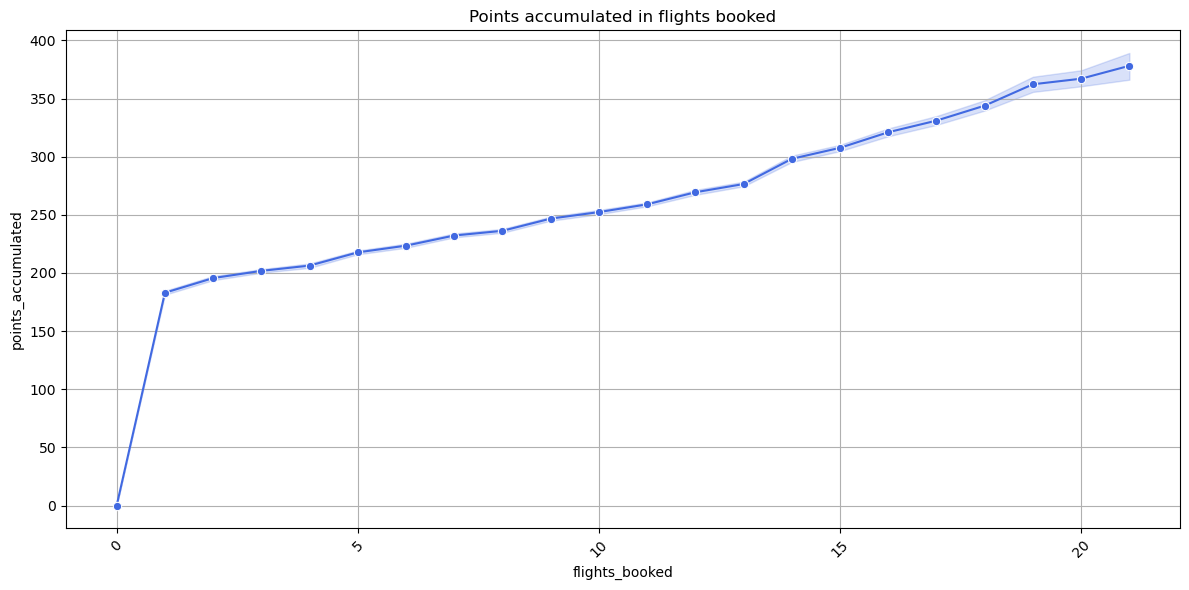

In [336]:
# Gráfico de líneas 
# Muestra la tendencia a lo largo del tiempo.

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_loyalflight, x='flights_booked', y='points_accumulated', marker="o", color='royalblue')
plt.title('Points accumulated in flights booked')
plt.xlabel('flights_booked')
plt.ylabel('points_accumulated')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretación:**
Podemos observar en la gráfica un crecimiento exponencial de los puntos acumulados por los clientes en función de la cantidad de vuelos que reservan.
Los puntos creceríann concretamente con fuerza a partir del primer vuelo reservado.

_________________________________________________________________________________________________________________

2. ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los cliente?
Variables numéricas:  
- distance: float
- points_accumulated: float

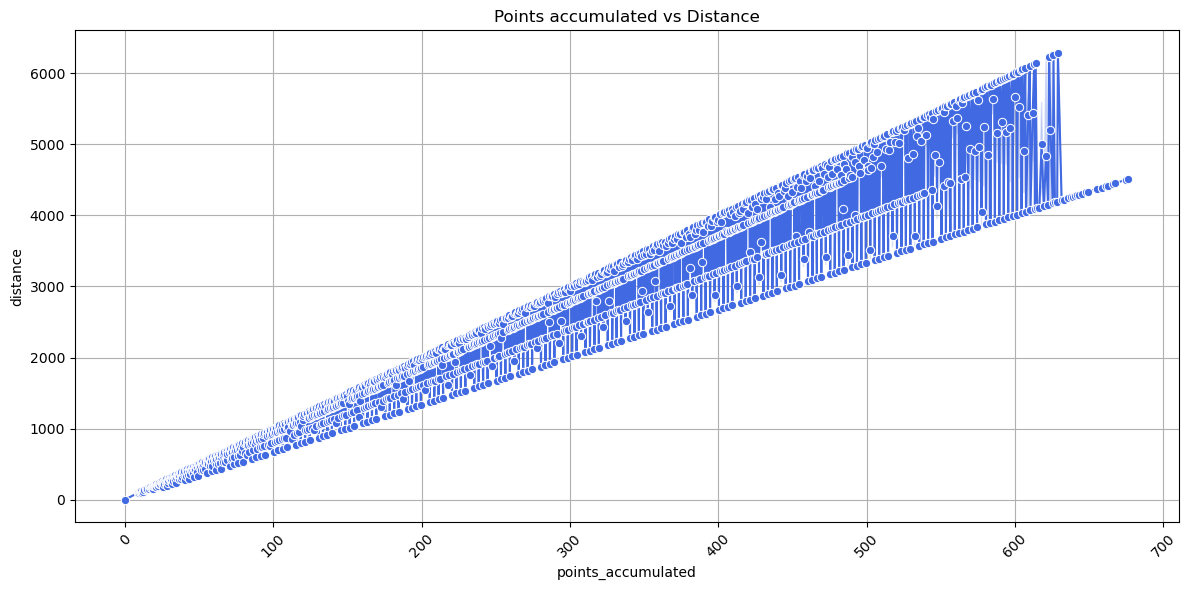

In [338]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_loyalflight, x='points_accumulated', y='distance', marker="o", color='royalblue')
plt.title('Points accumulated vs Distance')
plt.xlabel('points_accumulated')
plt.ylabel('distance')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretación:**
Nos encontramos ante un gráfico de lineas con elevada cantidad den dato, lo cual explica el exceso de líneas y puntos observados que representarían los puntos que acumularían los clientes según la distancia que viajan. 
Observamos claramente una ascensión de las líneas y puntos, lo cual mostraría una correlación positiva entre ambas variables, cuanto más distancia se recorre en los vuelos mayor es el número de puntos acumulados de la membresía.

_________________________________________________________________________________________________________________

3. ¿Cuál es la distribución de los clientes por provincia o estado?
- loyalty_id : int
- province : object

In [351]:
# Primero creamos una tabla con la agrurpación de los datos
df_nuevo = df_loyalflight.groupby('province')['loyalty_id'].nunique().sort_values(ascending=False)

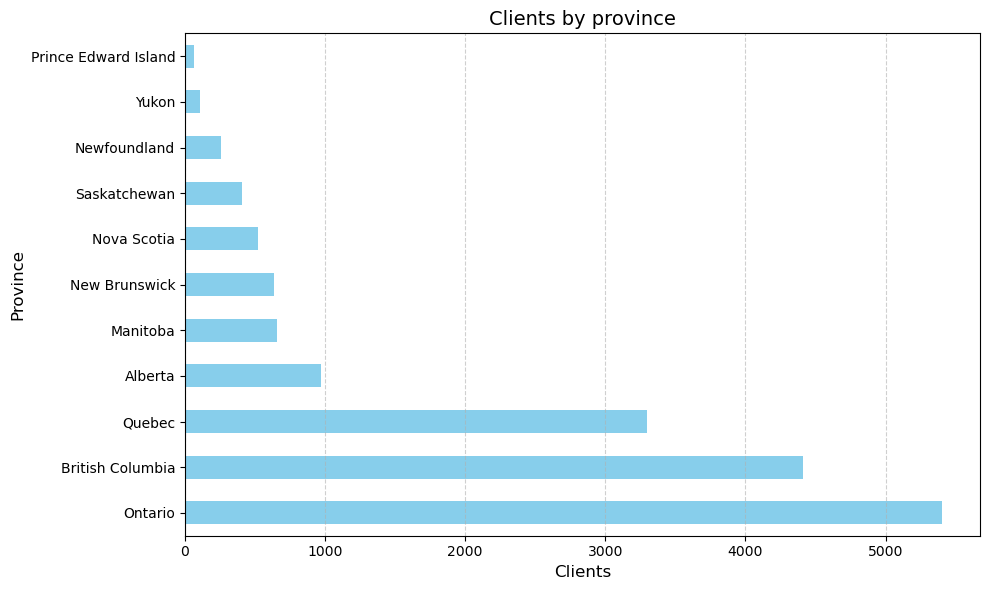

In [350]:
# Gráfico de barras
plt.figure(figsize=(10, 6))
df_nuevo.plot(kind='barh', color='skyblue')  # Horizontal para mejor lectura
plt.title('Clients by province', fontsize=14)
plt.xlabel('Clients', fontsize=12)
plt.ylabel('Province', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

_________________________________________________________________________________________________________________

**Interpretación:**
Los resultados muestran que habría más de 5000 clientes que pertenecerían a la provincia de Ontario de Canadá, le sigue British Columbia y Quebec.

4. . ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?
- salary
- education

In [352]:
# Calculemos el salario promcedio
salario_promedio = df_loyalflight.groupby('education_level')['salary'].mean().sort_values(ascending=False)
print(salario_promedio)

education_level
5    178335.439516
4    103767.494163
3     73455.000000
2     72601.235033
1     61112.377525
Name: salary, dtype: float64


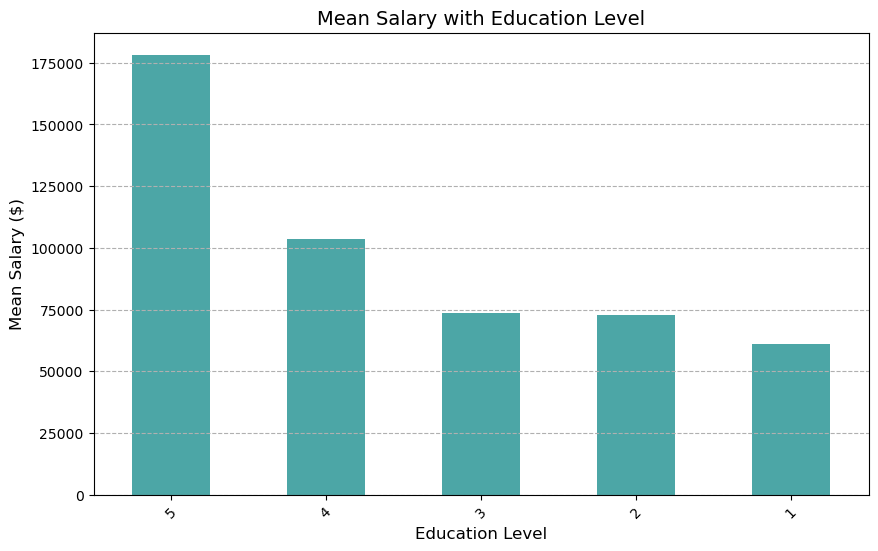

In [381]:
# Gráfico de barras

plt.figure(figsize=(10, 6))
salario_promedio.plot(kind='bar', color='teal', alpha=0.7)
plt.title('Mean Salary with Education Level', fontsize=14)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Mean Salary ($)', fontsize=12)
plt.xticks(rotation=45)  # Rotar etiquetas si son largas
plt.grid(axis='y', linestyle='--')
plt.show()

In [362]:
# Entendiendo los datos de educación
leyenda = {'High School or Below': 1,
            'Bachelor': 2,
            'College': 3,
            'Master': 4,
            'Doctor': 5}

**Interpretación:**
Es relevante la observación de este gráfico pues nos indicaría que el salario medio de los clientes con la membresía podría ser alto y relacionarse directamente con el nivel de estudios más alto. 

_________________________________________________________________________________________________________________

5. ¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?
- loyalty_card
- loyalty_id

In [ ]:
# Primero debemos obtener una table con la información que necesitamos
df_proporcion = df_loyalflight.groupby('loyalty_card')['loyalty_id'].nunique().reset_index()
df_proporcion.columns = ['loyalty_card', 'loyalty_id']

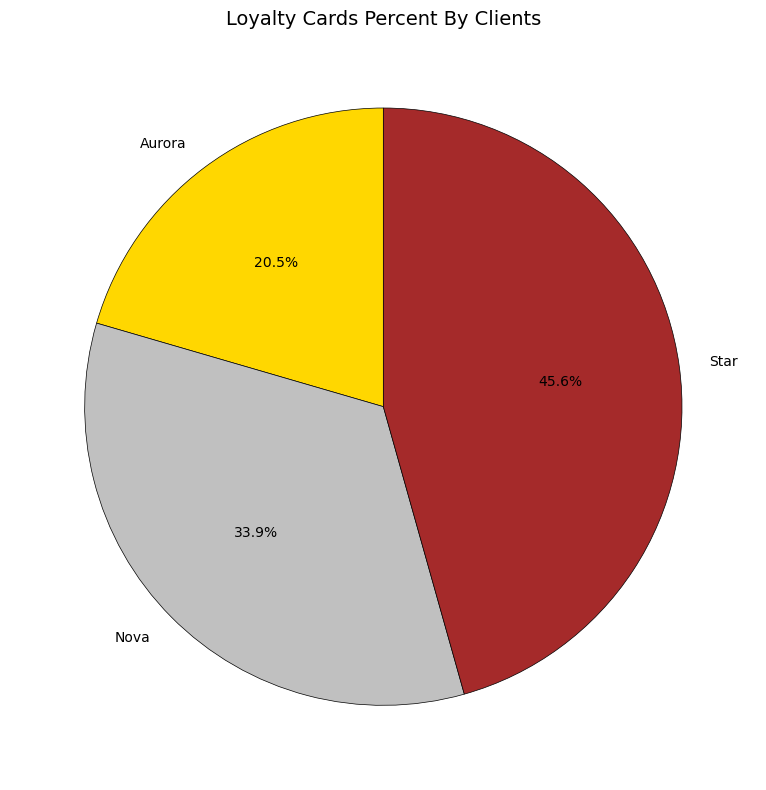

In [369]:
# Gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(
    df_proporcion['loyalty_id'],
    labels=df_proporcion['loyalty_card'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['gold', 'silver', 'brown'],
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.5}
)
plt.title('Loyalty Cards Percent By Clients', fontsize=14)
plt.tight_layout()
plt.show()

**Interpretación:**
El gráfico muestra que los clientes harían más uso de la tarjeta de un rango más bajo (Star), después usarían la de mayor rango o estatus: tipo Nova.

_________________________________________________________________________________________________________________

6. ¿Cómo se distribuyen los clientes según su estado civil y género?
- marital_status
- gender

In [367]:
# Contar clientes únicos por género y estado civil
df_distribucion = df_loyalflight.groupby(['marital_status', 'gender'])['loyalty_id'].nunique().unstack()
print(df_distribucion)

gender          Female  Male
marital_status              
Divorced          1269  1249
Married           4869  4866
Single            2272  2212


<Figure size 1000x600 with 0 Axes>

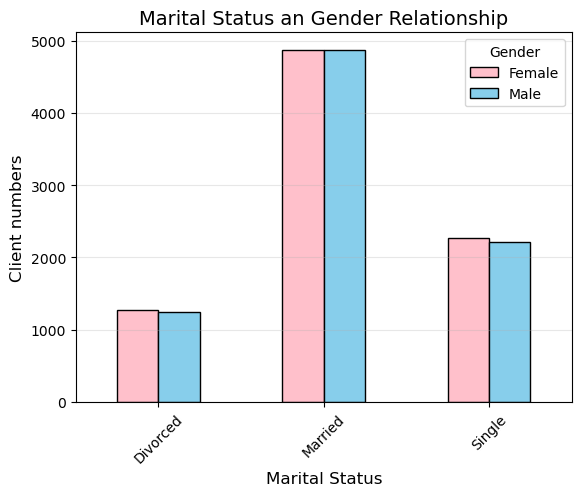

In [368]:
# Gráfico de barras agrupadas
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
df_distribucion.plot(kind='bar', color=['pink', 'skyblue'], edgecolor='black')
plt.title('Marital Status an Gender Relationship', fontsize=14)
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Client numbers', fontsize=12)
plt.legend(title='Gender', labels=['Female', 'Male'])
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

**Interpretación:**
La gráfica nos muestra que la moda respecto a el estado civil es "casado:  married", se observa que habría más clientes casados que solteros o divorciados sin encontrar diferencia entre hombres y mujeres.